In [15]:
# %matplotlib qt 

# %matplotlib inline

import typing as T

import numpy as np
import scipy as sp

from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator

from pydrake.solvers import (  
    MathematicalProgram,
    Solve,
)
from pydrake.symbolic import Polynomial, Variable, Variables

from util import timeit, diditwork

FREE_POLY = "free_poly"
PSD_POLY = "psd_poly"
PSD_ON_REGION_POLY = "psd_on_region"

In [16]:
%matplotlib widget

In [94]:
class Vertex:
    def __init__(self, name:str, prog: MathematicalProgram, x_min:float, x_max:float, y_min:float, y_max:float, potential_poly_deg=2, multiplier_deg = 4, pot_type=FREE_POLY, make_target=False):
        self.bounds = {"x_min": x_min, "x_max":x_max, "y_min":y_min, "y_max":y_max}
        self.name = name
        self.potential_poly_deg = potential_poly_deg
        self.multiplier_deg = multiplier_deg
        
        self.define_variables(prog)
        self.define_set_vector()
        self.define_potential(prog, pot_type, make_target)

    def define_variables(self, prog: MathematicalProgram):
        self.x = prog.NewIndeterminates(1, "x_" + self.name)[0]
        self.y = prog.NewIndeterminates(1, "y_" + self.name)[0]
        self.vars = Variables([self.x, self.y])

    def define_potential(self, prog: MathematicalProgram, pot_type:str, make_target):
        if make_target:
            self.potential = Polynomial(0)
            return

        # potential is a free polynomial
        if pot_type == FREE_POLY:
            self.potential = prog.NewFreePolynomial(self.vars, self.potential_poly_deg)
        elif pot_type == PSD_POLY:
            # potential is PSD polynomial
            self.potential, _ = prog.NewSosPolynomial(self.vars, self.potential_poly_deg)
        elif pot_type == PSD_ON_REGION_POLY:
            # potential is PSD on its region
            self.potential = prog.NewFreePolynomial(self.vars, self.potential_poly_deg)
            multiplier1, _ = prog.NewSosPolynomial(self.vars, self.multiplier_deg)
            multiplier2, _ = prog.NewSosPolynomial(self.vars, self.multiplier_deg)
            multipliers = np.array([multiplier1, multiplier2])
            prog.AddSosConstraint( self.potential + multipliers.dot(self.convex_set_poly) )

    def define_set_vector(self):
        # represent using a square
        # i want a function g that's only negative on the box
        # (x - x_min)*(x - x_max) <= fits the description
        x_min, x_max = self.bounds["x_min"], self.bounds["x_max"] 
        y_min, y_max = self.bounds["y_min"], self.bounds["y_max"]
        x, y = self.x, self.y
        self.convex_set_poly = np.array([Polynomial((x - x_min)*(x - x_max)), Polynomial((y - y_min)*(y - y_max))])
        if self.name == "vt":
            self.convex_set_poly = np.zeros(2)

    def evaluate_partial_potential_at_point(self, x, y):
        return self.potential.EvaluatePartial({self.x:x, self.y:y})
    
    def evaluate_at_a_grid(self, solution, X, Y):       
        # define a function for evaluating points
        poly = solution.GetSolution(self.potential)
        eval_func = lambda x,y: poly.Evaluate({self.x:x, self.y:y})
        # vectorize
        np_eval_func = np.vectorize(eval_func)
        return np_eval_func(X, Y)
    
    def make_a_surface(self, solution, ax, max_pot = None, vmin = 0, vmax = 20):
        # make the grid
        x_min, x_max = self.bounds["x_min"], self.bounds["x_max"] 
        y_min, y_max = self.bounds["y_min"], self.bounds["y_max"]
        small = False
        if x_max-x_min < 0.1:
            x_max += 0.05
            x_min -= 0.05
            small = True
        if y_max-y_min < 0.1:
            y_max += 0.05
            y_min -= 0.05
            small = True
        grid_resolution = np.max([0.1,(x_max-x_min)/15, (y_max-y_min)/15 ])
        X = np.hstack((np.arange(x_min,x_max,grid_resolution), x_max))
        Y = np.hstack((np.arange(y_min,y_max,grid_resolution), y_max))
        X, Y = np.meshgrid(X, Y)
        # get z values for the grid
        Z = self.evaluate_at_a_grid(solution, X, Y)
        if max_pot is not None:
            Z = np.clip(Z, 0, max_pot)
        return ax.plot_surface(X, Y, Z, cmap=cm.viridis, linewidth=0,vmin=vmin, vmax=vmax, antialiased=False)
    
    def cost_at_point(self, x,y, solution=None):
        if solution is None:
            return self.evaluate_partial_potential_at_point(x,y).ToExpression()
        else: 
            return solution.GetSolution(self.potential).Evaluate({self.x:x, self.y:y})

    def cost_at_center(self, solution = None):
        x = 0.5*(self.bounds["x_min"] + self.bounds["x_max"])
        y = 0.5*(self.bounds["y_min"] + self.bounds["y_max"])
        return self.cost_at_point(x,y,solution)
    
    def cost_of_integral(self, solution=None):
        poly = self.potential
        x_min, x_max = self.bounds["x_min"], self.bounds["x_max"] 
        y_min, y_max = self.bounds["y_min"], self.bounds["y_max"]
        x, y = self.x, self.y
        poly_int_in_y = poly.Integrate(y)
        poly_in_x = poly_int_in_y.EvaluatePartial({y:y_max}) - poly_int_in_y.EvaluatePartial({y:y_min})
        poly_int_in_x = poly_in_x.Integrate(x)
        integral_over_area = poly_int_in_x.EvaluatePartial({x:x_max}) - poly_int_in_x.EvaluatePartial({x:x_min})
        if solution is None:
            return integral_over_area.ToExpression()
        else:
            return solution.GetSolution(integral_over_area)
        
    def cost_of_small_integral_at_center(self, solution=None):
        poly = self.potential
        eps = 0.001
        x = 0.5*(self.bounds["x_min"] + self.bounds["x_max"])
        y = 0.5*(self.bounds["y_min"] + self.bounds["y_max"])
        x_min, x_max = x-eps,x+eps
        y_min, y_max = y-eps,y+eps
        x, y = self.x, self.y
        poly_int_in_y = poly.Integrate(y)
        poly_in_x = poly_int_in_y.EvaluatePartial({y:y_max}) - poly_int_in_y.EvaluatePartial({y:y_min})
        poly_int_in_x = poly_in_x.Integrate(x)
        integral_over_area = poly_int_in_x.EvaluatePartial({x:x_max}) - poly_int_in_x.EvaluatePartial({x:x_min})
        if solution is None:
            return integral_over_area.ToExpression()
        else:
            return solution.GetSolution(integral_over_area)


class CenteredVertex(Vertex):
    def __init__(self, name:str, prog: MathematicalProgram, x,y, w,h, potential_poly_deg=2, multiplier_deg = 4, pot_type=FREE_POLY):
        super(CenteredVertex, self).__init__(name, prog, x-w/2,x+w/2, y-h/2, y+h/2, potential_poly_deg, multiplier_deg, pot_type)

class Edge:
    def __init__(self, v_left: Vertex, v_right: Vertex, prog: MathematicalProgram, multiplier_deg = 4):
        self.left = v_left
        self.right = v_right
        self.left_right_multiplier_degrees = multiplier_deg

        self.define_quadratic_cost_poly()
        self.define_multipliers(prog)
        self.add_edge_potential_diff_constraint(prog)

    def define_quadratic_cost_poly(self):
        self.edge_cost = Polynomial( (self.left.x - self.right.x)**2 + (self.left.y - self.right.y)**2)

    def define_multipliers(self, prog: MathematicalProgram):

        vars = Variables([self.left.x, self.left.y, self.right.x, self.right.y])
        
        poly1,_ = prog.NewSosPolynomial(vars, self.left_right_multiplier_degrees)
        poly2,_ = prog.NewSosPolynomial(vars, self.left_right_multiplier_degrees)
        # poly1,_ = prog.NewSosPolynomial(self.left.vars, self.left_right_multiplier_degrees)
        # poly2,_ = prog.NewSosPolynomial(self.left.vars, self.left_right_multiplier_degrees)
        self.left_multipliers = np.array([poly1, poly2])

        if self.right.name == "vt":
            self.right_multipliers = np.zeros(2)
        else:
            # poly1,_ = prog.NewSosPolynomial(self.right.vars, self.left_right_multiplier_degrees)
            # poly2,_ = prog.NewSosPolynomial(self.right.vars, self.left_right_multiplier_degrees)
            poly1,_ = prog.NewSosPolynomial(vars, self.left_right_multiplier_degrees)
            poly2,_ = prog.NewSosPolynomial(vars, self.left_right_multiplier_degrees)
            self.right_multipliers = np.array([poly1, poly2])

    # def add_edge_potential_diff_constraint(self, prog: MathematicalProgram, flipsign=False):
    #     expr = (
    #         self.edge_cost
    #         - (self.left.potential - self.right.potential)
    #         + self.left_multipliers.dot(self.left.convex_set_poly)
    #         + self.right_multipliers.dot(self.right.convex_set_poly) 
    #     )
    #     poly, _ = prog.NewSosPolynomial(Variables([self.left.x, self.left.y, self.right.x, self.right.y]), self.left_right_multiplier_degrees)
    #     prog.AddEqualityConstraintBetweenPolynomials(expr, poly)

    def add_edge_potential_diff_constraint(self, prog: MathematicalProgram, flipsign=False):
        g, _ = prog.NewSosPolynomial(Variables([self.left.x, self.left.y, self.right.x, self.right.y]), self.left_right_multiplier_degrees)
        delta = self.left.potential - self.right.potential - self.edge_cost
        f = -(delta + self.left_multipliers.dot(self.left.convex_set_poly) + self.right_multipliers.dot(self.right.convex_set_poly))

        g, _ = prog.NewSosPolynomial(Variables([self.left.x, self.left.y, self.right.x, self.right.y]), self.left_right_multiplier_degrees)
        h, _ = prog.NewSosPolynomial(Variables([self.left.x, self.left.y, self.right.x, self.right.y]), self.left_right_multiplier_degrees)
    
        prog.AddEqualityConstraintBetweenPolynomials(f + h, Polynomial(-1) )
        # prog.AddEqualityConstraintBetweenPolynomials(f + h, - g )

solve successful!
104.02000576558203
SolutionResult.kSolutionFound
Solver is Mosek
Solver status: <pydrake.solvers.MosekSolverDetails object at 0x2cc81ccf0>
Potential at s1: 52.010002962398175
Potential at s2: 52.01000280318385


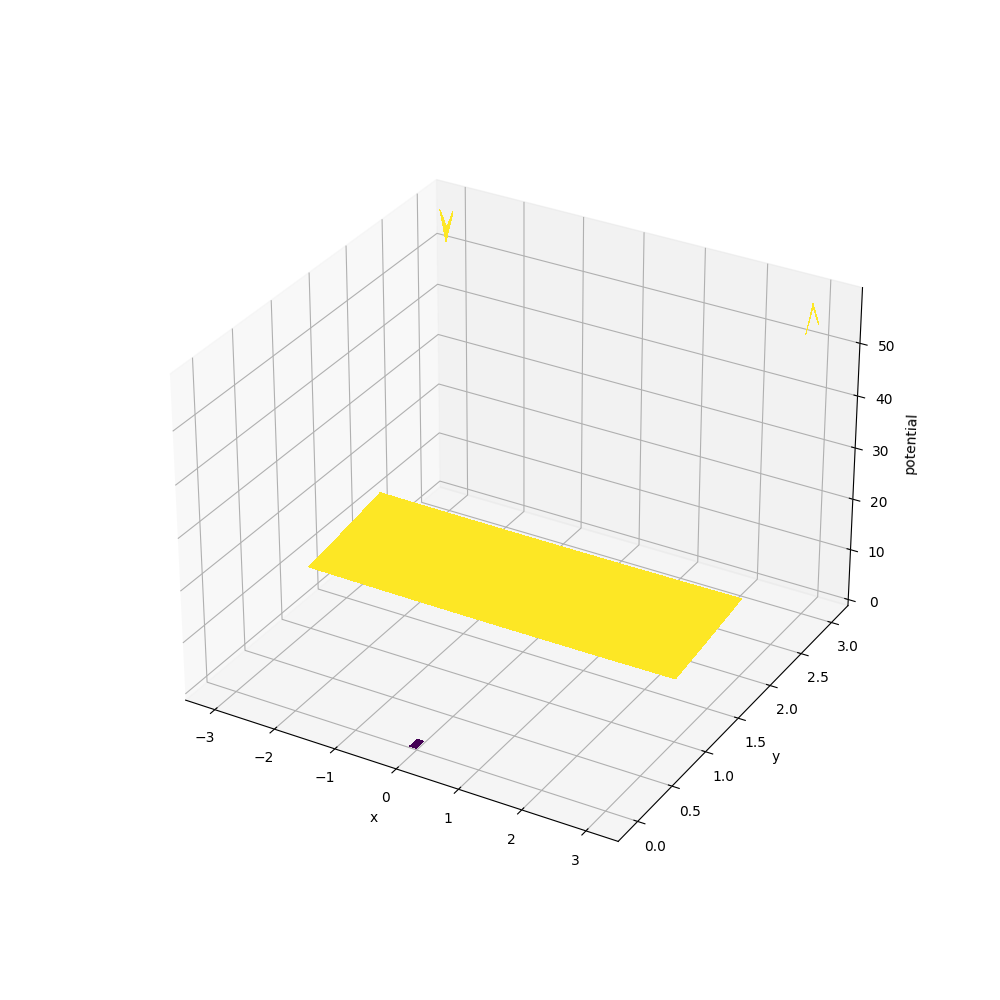

In [95]:
pot_degree = 2
multiplier_deg = 2
eps = 0.001

prog = MathematicalProgram()

vertices = []
vt = Vertex("t", prog, -eps, eps, -eps, eps, pot_degree, multiplier_deg, make_target = True)
v1 = Vertex("1", prog, -3,3, 1,2, pot_degree, multiplier_deg)
s1 = Vertex("s1", prog, -3-eps,-3+eps, 3-eps,3+eps, pot_degree, multiplier_deg)
s2 = Vertex("s2", prog, 3-eps,3+eps, 3-eps,3+eps, pot_degree, multiplier_deg)

vertices = [vt, v1, s1, s2]
# vertices = [vt, v1]

e2 = Edge(s2, v1, prog, multiplier_deg)
e1 = Edge(s1, v1, prog, multiplier_deg)
e0 = Edge(v1, vt, prog, multiplier_deg)

# potential is zero at target point
prog.AddEqualityConstraintBetweenPolynomials(vt.evaluate_partial_potential_at_point(0,0), Polynomial(0) )

# prog.AddEqualityConstraintBetweenPolynomials(s1.evaluate_partial_potential_at_point(-3,3), Polynomial(8.8) )

# maximize potential at start point
cost = s1.cost_at_center() + s2.cost_at_center()
# cost = v1.cost_of_integral()
# cost = v1.cost_at_point(3,2)
# cost = s1.cost_of_integral() + s2.cost_of_integral()
prog.AddLinearCost( cost )

solution = Solve(prog)

diditwork(solution)

assert solution.is_success()
print("Potential at s1:", s1.cost_at_center(solution))
print("Potential at s2:", s2.cost_at_center(solution))



fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
fig.set_figheight(10)
fig.set_figwidth(10)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("potential")
# ax.view_init(elev=90, azim=-90)

for v in vertices:
    max_cutoff = None
    if v.name == "t":
        max_cutoff = 0
    v.make_a_surface(solution, ax, max_pot = max_cutoff, vmin=0, vmax=6)

plt.show()

solve successful!
-14.02812711215277
SolutionResult.kSolutionFound
Solver is Mosek
Solver status: <pydrake.solvers.MosekSolverDetails object at 0x17ac181b0>


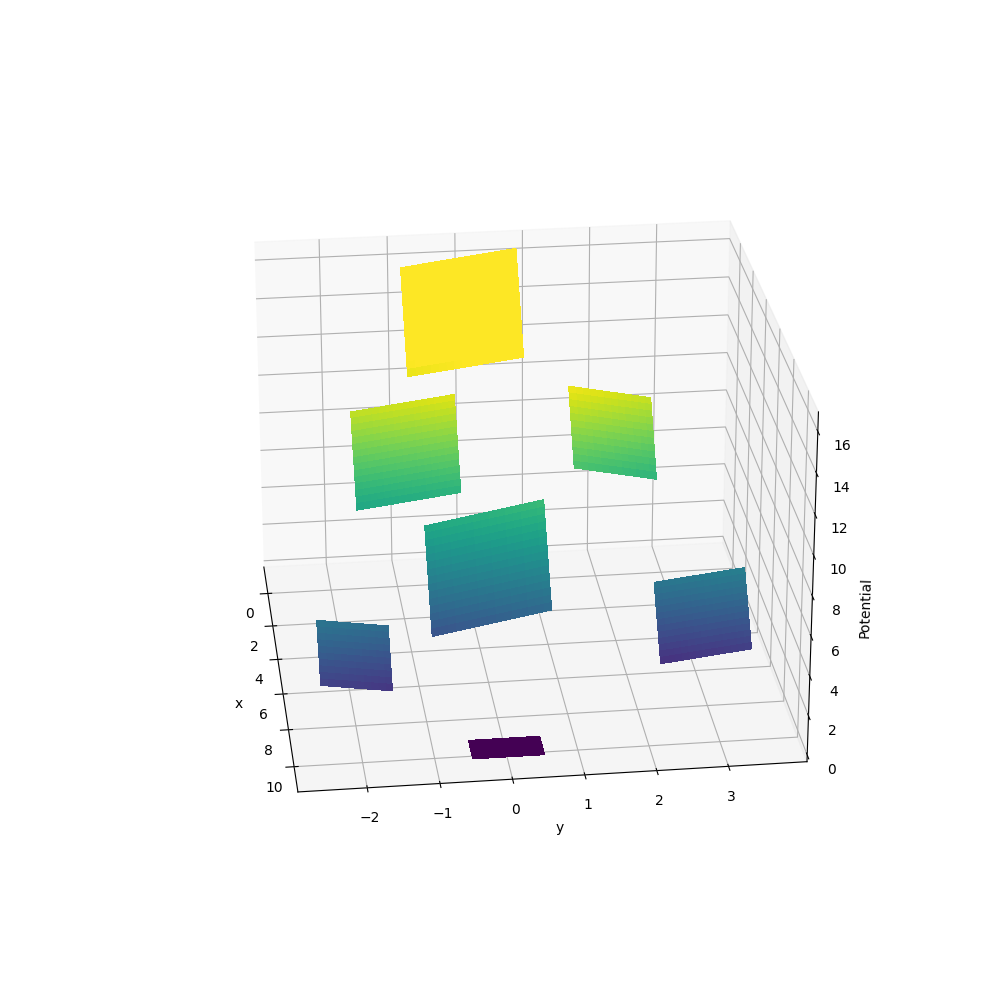

In [10]:
pot_degree = 1
multiplier_deg = 2
eps = 0.001

prog = MathematicalProgram()

vertices = []
vt = CenteredVertex("t", prog, 10,0, 1,1, pot_degree, multiplier_deg)
v1 = CenteredVertex("1", prog, 8,-2, 1,1, pot_degree, multiplier_deg)
v2 = CenteredVertex("2", prog, 7,3, 1.3,1.3, pot_degree, multiplier_deg)
v3 = CenteredVertex("3", prog, 6,0, 1.7,1.7, pot_degree, multiplier_deg)
v4 = CenteredVertex("4", prog, 3,-1, 1.5,1.5, pot_degree, multiplier_deg)
v5 = CenteredVertex("5", prog, 3,2, 1.2,1.2, pot_degree, multiplier_deg)
vs = CenteredVertex("s", prog, 0,0, 1.7,1.7, pot_degree, multiplier_deg)

vertices = [vt, v1, v2, v3, v4, v5, vs]

Edge(vs, v4, prog, multiplier_deg)
Edge(vs, v5, prog, multiplier_deg)
Edge(v4, v3, prog, multiplier_deg)
Edge(v4, v1, prog, multiplier_deg)
Edge(v5, v3, prog, multiplier_deg)
Edge(v5, v2, prog, multiplier_deg)
Edge(v2, v3, prog, multiplier_deg)
Edge(v2, vt, prog, multiplier_deg)
Edge(v2, vt, prog, multiplier_deg)
Edge(v3, v1, prog, multiplier_deg)
Edge(v1, v2, prog, multiplier_deg)
Edge(v1, vt, prog, multiplier_deg)


# potential is zero at target point
prog.AddEqualityConstraintBetweenPolynomials(vt.evaluate_partial_potential_at_point(10,0), Polynomial(0) )

# maximize potential at start point
# cost = s1.cost_at_center() + s2.cost_at_center()
# cost = s1.cost_of_integral() + s2.cost_of_integral()
cost = vs.cost_at_center()
# prog.AddLinearCost( -cost )
prog.AddLinearCost( -cost )

solution = Solve(prog)


diditwork(solution)
# assert solution.is_success()
# print("Potential at s1:", s1.cost_at_center(solution))
# print("Potential at s2:", s2.cost_at_center(solution))



fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
fig.set_figheight(10)
fig.set_figwidth(10)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("Potential")
ax.view_init(elev=25, azim=-7)

for v in vertices:
    max_cutoff = None
    if v.name == "t":
        max_cutoff = 0
    v.make_a_surface(solution, ax, max_pot = max_cutoff, vmin=0, vmax=12)

plt.show()

# Example 1: maximize potential at two symmetric points simultaniously

For degree 1 -- linear -- we get 4.5 per point.
For degree 2 -- quadratic -- we get 9 per point, which is the true potential.

Potential at s1: 25.000190300660506
Potential at s2: 25.000190667519746


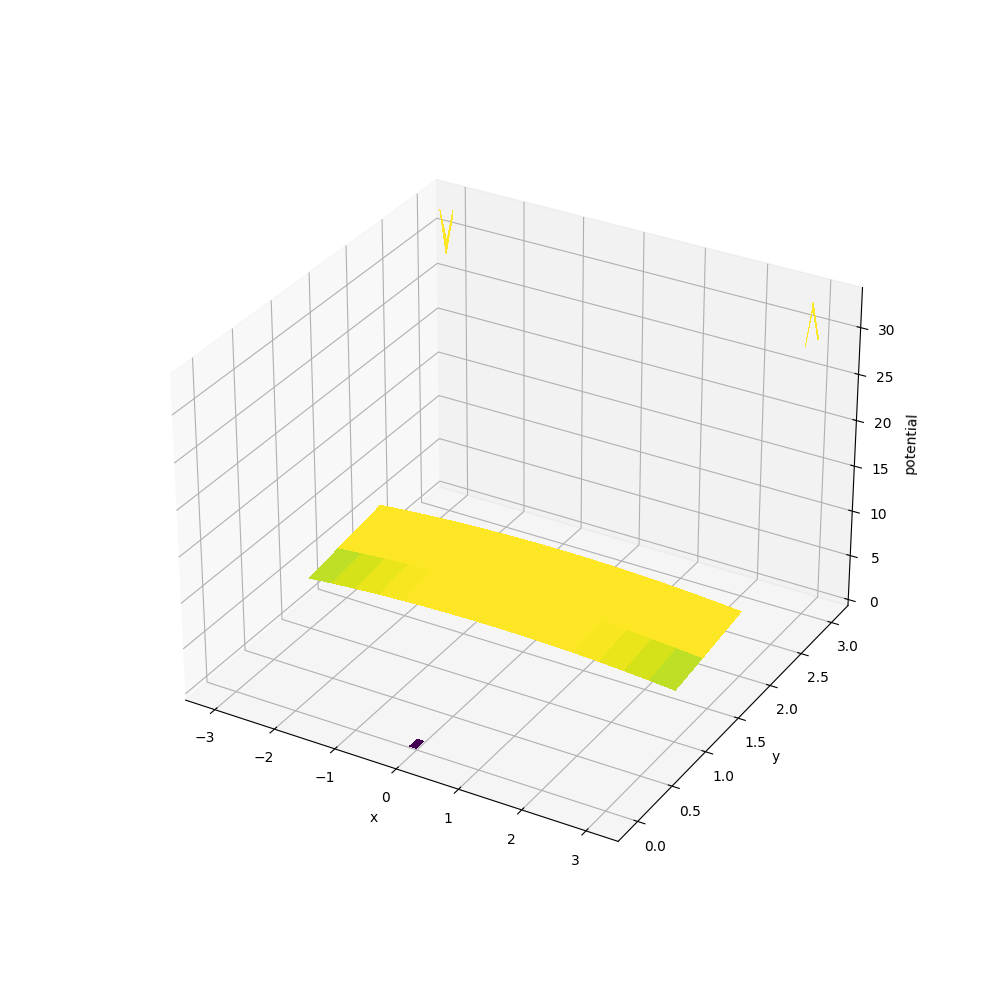

In [14]:
pot_degree = 2
multiplier_deg = 4
eps = 0.001

prog = MathematicalProgram()

vertices = []
vt = Vertex("t", prog, -eps, eps, -eps, eps, pot_degree, multiplier_deg)
v1 = Vertex("1", prog, -3,3, 1,2, pot_degree, multiplier_deg)
s1 = Vertex("s1", prog, -3-eps,-3+eps, 3-eps,3+eps, pot_degree, multiplier_deg)
s2 = Vertex("s2", prog, 3-eps,3+eps, 3-eps,3+eps, pot_degree, multiplier_deg)

vertices = [vt, v1, s1, s2]

e2 = Edge(s2, v1, prog, multiplier_deg,True)
e1 = Edge(s1, v1, prog, multiplier_deg,True)
e0 = Edge(v1, vt, prog, multiplier_deg,True)

# potential is zero at target point
prog.AddEqualityConstraintBetweenPolynomials(vt.evaluate_partial_potential_at_point(0,0), Polynomial(0) )

# prog.AddEqualityConstraintBetweenPolynomials(s1.evaluate_partial_potential_at_point(-3,3), Polynomial(8.8) )

# maximize potential at start point
cost = s1.cost_at_center() + s2.cost_at_center()
# cost = s1.cost_of_integral() + s2.cost_of_integral()
prog.AddLinearCost( cost )

solution = Solve(prog)


assert solution.is_success()
print("Potential at s1:", s1.cost_at_center(solution))
print("Potential at s2:", s2.cost_at_center(solution))



fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
fig.set_figheight(10)
fig.set_figwidth(10)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("potential")
# ax.view_init(elev=90, azim=-90)

for v in vertices:
    max_cutoff = None
    if v.name == "t":
        max_cutoff = 0
    v.make_a_surface(solution, ax, max_pot = max_cutoff, vmin=0, vmax=6)

plt.show()

In [25]:
pot_degree = 2
multiplier_deg = 4
eps = 0.001

prog = MathematicalProgram()

vertices = []
vt = Vertex("t", prog, -eps, eps, -eps, eps, pot_degree, multiplier_deg)
v1 = Vertex("1", prog, -3,0,1,1.5, pot_degree, multiplier_deg)

v15 = Vertex("2", prog, 0,3,2,2.5, pot_degree, multiplier_deg)

v2 = Vertex("2", prog, -3,3,3,4, pot_degree, multiplier_deg)


s1 = Vertex("s1", prog, -3-eps,-3+eps, 5-eps,5+eps, pot_degree, multiplier_deg)
s2 = Vertex("s2", prog,  2-eps, 2+eps, 6-eps,6+eps, pot_degree, multiplier_deg)

s3 = Vertex("s3", prog, -7-eps,-7+eps, 6-eps,6+eps, pot_degree, multiplier_deg)
s4 = Vertex("s4", prog,  7-eps, 7+eps, 9-eps,9+eps, pot_degree, multiplier_deg)

s5 = Vertex("s5", prog, -5-eps,-5+eps, 9-eps,9+eps, pot_degree, multiplier_deg)
s6 = Vertex("s6", prog,  4-eps, 4+eps, 8-eps,8+eps, pot_degree, multiplier_deg)



e5 = Edge(s5, v2, prog, multiplier_deg)
e6 = Edge(s6, v2, prog, multiplier_deg)

vertices = [vt, v1, v15,v2, s1,s2,s3,s4,s5,s6]

e3 = Edge(s3, v2, prog, multiplier_deg)
e4 = Edge(s4, v2, prog, multiplier_deg)
e2 = Edge(s2, v2, prog, multiplier_deg)
e1 = Edge(s1, v2, prog, multiplier_deg)

ee = Edge(v2, v15, prog, multiplier_deg)
ee = Edge(v15, v1, prog, multiplier_deg)
e0 = Edge(v1, vt, prog, multiplier_deg)

# potential is zero at target point
prog.AddEqualityConstraintBetweenPolynomials(vt.evaluate_partial_potential_at_point(0,0), Polynomial(0) )

# prog.AddEqualityConstraintBetweenPolynomials(s1.evaluate_partial_potential_at_point(-3,3), Polynomial(8.8) )

# maximize potential at start point

cost = 0

# cost += s1.cost_at_center() + s2.cost_at_center() #11.3 each

cost += s3.cost_at_center() + s4.cost_at_center() # 32.5

# cost += s5.cost_at_center() + s6.cost_at_center() #11.3 each

# cost = s1.cost_at_center() + s2.cost_at_center() + s3.cost_at_center() + s4.cost_at_center() + s5.cost_at_center() + s6.cost_at_center()


# cost = s1.cost_of_integral() + s2.cost_of_integral() + s3.cost_of_integral() + s4.cost_of_integral()
# cost = s1.cost_of_integral() + s2.cost_of_integral()

prog.AddLinearCost( -cost )

solution = Solve(prog)


assert solution.is_success()
print("Potential at s1:", s1.cost_at_center(solution))
print("Potential at s2:", s2.cost_at_center(solution))
print("Potential at s3:", s3.cost_at_center(solution))
print("Potential at s4:", s4.cost_at_center(solution))
print("Potential at s5:", s5.cost_at_center(solution))
print("Potential at s6:", s6.cost_at_center(solution))


# Potential at s1: 10.619825870733166
# Potential at s2: 9.588908931310698
# Potential at s3: 33.905384371591936
# Potential at s4: 50.67672494141334
# Potential at s5: 42.61362514879784
# Potential at s6: 26.097951993869174

Potential at s1: -29733.62552477185
Potential at s2: -31805.074887910905
Potential at s3: 17.120106353429037
Potential at s4: 25.392018792859744
Potential at s5: -64097.352995477646
Potential at s6: -51663.95795484483


# Example 2: symmetric path split

Solve time took 0.087s
Potential at start: 8.999907298699668


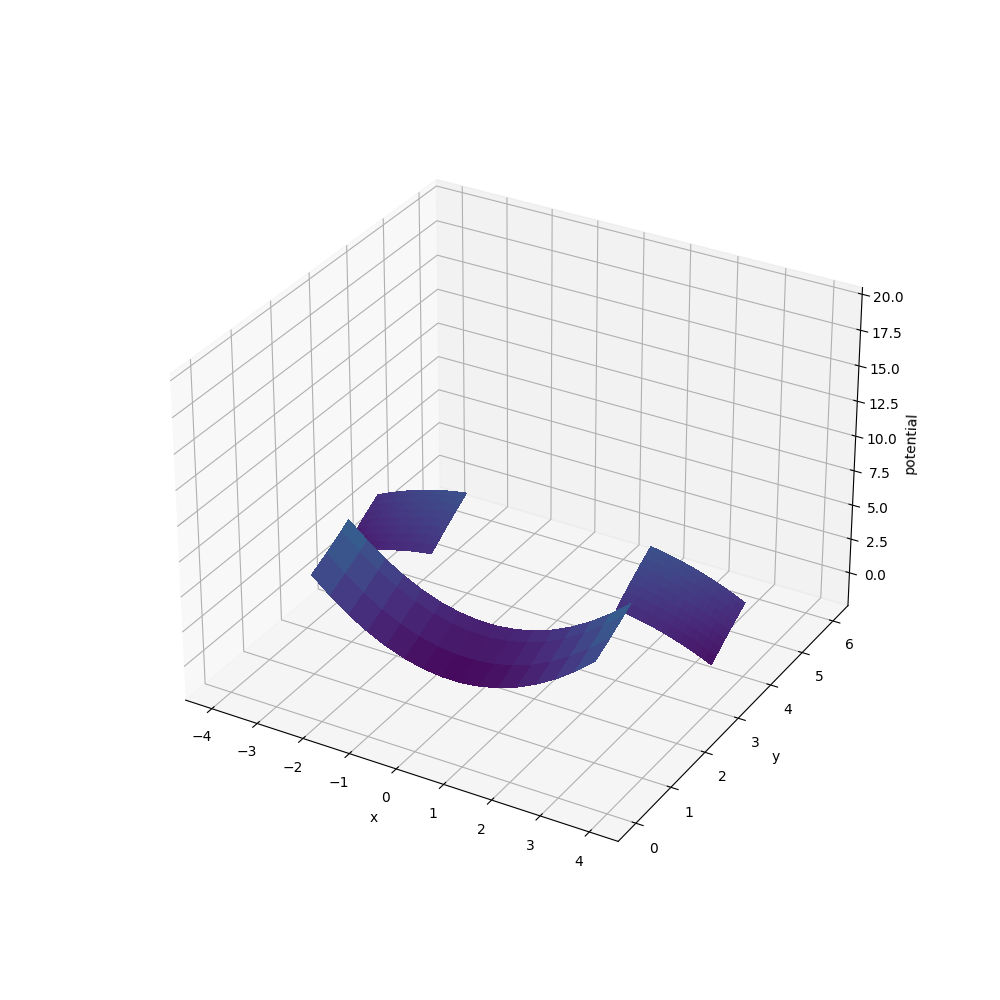

In [27]:
pot_degree = 2
multiplier_deg = 16
eps = 0.001

prog = MathematicalProgram()

vertices = []
vt = Vertex("t", prog, -eps, eps, -eps, eps, pot_degree, multiplier_deg)
v1 = Vertex("1", prog, -3,3, 1,2, pot_degree, multiplier_deg)
v2 = Vertex("2", prog, -4,-2, 3,4, pot_degree, multiplier_deg)
v3 = Vertex("3", prog, 2,4, 3,4, pot_degree, multiplier_deg)
# vs = Vertex("vs", prog, -3,3, 5,7, pot_degree, multiplier_deg, FREE_POLY)
vs = Vertex("vs", prog, -eps,eps, 6-eps,6+eps, pot_degree, multiplier_deg, FREE_POLY)
# vs = Vertex("vs", prog, -1,1, 5,7, pot_degree, multiplier_deg, FREE_POLY)

# vertices = [vt,v1,v2,vs]
vertices = [vt,v1,v2,v3,vs]

Edge(v1, vt, prog)
Edge(v2, v1, prog)
Edge(v3, v1, prog)
Edge(vs, v2, prog)
Edge(vs, v3, prog)

# potential is zero at target point

prog.AddEqualityConstraintBetweenPolynomials(vt.evaluate_partial_potential_at_point(0,0), Polynomial(0) )

# maximize potential at start point
# cost = vs.cost_at_center()

# maximize potential at a sample of points
cost = 0
cost += vs.cost_at_center()
# cost += vs.cost_of_integral()
# cost += v1.cost_of_integral()
# cost += v2.cost_of_integral()
# cost += v3.cost_of_integral()
# cost = vs.cost_of_small_integral_at_center()

# maximize potential over an integral

prog.AddLinearCost( -cost )

dt = timeit()
solution = Solve(prog)
dt.dt("Solve time")

# print(solution.GetSolution(vs.potential))


assert solution.is_success()
print("Potential at start:", vs.cost_at_center(solution))




fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
fig.set_figheight(10)
fig.set_figwidth(10)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("potential")
# ax.view_init(elev=90, azim=-90)

ax.set_zlim3d(-2, 20)
for v in vertices:
    max_cutoff = None
    if v.name == "t":
        max_cutoff = 0
    else: 
        max_cutoff = 30
    v.make_a_surface(solution, ax)
    # v.make_a_surface(solution, ax, max_cutoff, 0, 20)


plt.show()

In [77]:

np.max([0.1,2,3])

3.0

In [28]:
temp_prog = MathematicalProgram()
x_t = temp_prog.NewIndeterminates(1,"xt")[0]
y_t = temp_prog.NewIndeterminates(1,"yt")[0]

y_min, y_max = 0,1
x_min, x_max = 0,1




a(2)*1 + a(0)*yt(0) + a(1)*xt(0)
a(2)*yt(0) + (0.5 * a(0))*yt(0)^2 + a(1)*xt(0) * yt(0)
(0.5 * a(0) + a(2))*1 + a(1)*xt(0)
(0.5 * a(0) + a(2))*xt(0) + (0.5 * a(1))*xt(0)^2
(0.5 * a(0) + 0.5 * a(1) + a(2))*1
